# ДЗ:

1. Использовать датасет `telecom_churn.csv`
2. Обучить LogisticRegression. Использовать в качестве `baseline`.
3. Обучить на этом датасете все три вида ансамблей, использованных в этом ноутбуке. Сравнить с baseline
4. Использовать PCA для понижения размерности, или использовать статистическим методом отбор признаков SelectKBest. Затем обучить LogisticRegression в качестве `baseline`, и обучить все три вида ансамблей, рассмотренных в этом ноутбуке.
5. Сравнить результаты между собой до понижения размерности или отбора признаков, так и после них.


In [81]:
!pip3 install catboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split # разбиение данных на тренировочные и тестовые

from sklearn.compose import ColumnTransformer # преобразование столбцов
from sklearn.preprocessing import OneHotEncoder # кодирование категориальных переменных
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler # нормализация и масштабирование данных

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.model_selection import cross_val_score # кроссвалидация
from sklearn.model_selection import GridSearchCV # подбор гиперпараметров с кроссвалидацией


from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay


In [82]:
df = pd.read_csv('telecom_churn.csv')
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [83]:
df.Churn.value_counts()

False    2850
True      483
Name: Churn, dtype: int64

In [84]:
categorical_features = ['State', 'International plan', 'Voice mail plan', 'Churn']

for i in categorical_features:
  df[i] = pd.Categorical(df[i]).codes

df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,192,415,0,1,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0
3329,49,68,415,0,0,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,0
3330,39,28,510,0,0,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,0
3331,6,184,510,1,0,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0


In [85]:
df.isnull().values.any()

False

In [86]:
df.isna().values.any()

False

In [87]:
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(df.drop(categorical_features, axis=1))
df_scaled = df.copy()
numerical_features = [col for col in df.columns if col not in (categorical_features)]
df_scaled[numerical_features] = scaler.fit_transform(df[numerical_features])
df = df_scaled
df

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,16,0.676489,-0.523603,0,1,1.234883,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,-0.465494,0.866029,-0.085008,-0.601195,-0.085690,-0.427932,0
1,35,0.149065,-0.523603,0,1,1.307948,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,0.147825,1.059390,1.240482,-0.601195,1.241169,-0.427932,0
2,31,0.902529,-0.523603,0,0,-0.591760,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,0.198935,-0.755571,0.703121,0.211534,0.697156,-1.188218,0
3,35,-0.428590,-0.688834,1,0,-0.591760,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,-0.567714,-0.078806,-1.303026,1.024263,-1.306401,0.332354,0
4,36,-0.654629,-0.523603,1,0,-0.591760,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,1.067803,-0.276562,-0.049184,-0.601195,-0.045885,1.092641,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,2.283878,-0.523603,0,1,2.038605,-0.432895,-1.167924,-0.433386,0.286348,1.299506,0.286880,1.547039,-0.874374,1.547188,-0.120832,0.617898,-0.125496,0.332354,0
3329,49,-0.830437,-0.523603,0,0,-0.591760,0.942447,-2.164631,0.942714,-0.938353,-2.264816,-0.938172,-0.189297,1.170023,-0.188670,-0.228304,-0.194831,-0.231645,1.092641,0
3330,39,-1.835055,1.718817,0,0,-0.591760,0.018820,0.426808,0.019193,1.731930,-2.114211,1.732349,-0.177431,-0.465494,-0.175486,1.383778,0.617898,1.387123,0.332354,0
3331,6,2.082955,1.718817,1,0,-0.591760,0.624778,0.227466,0.625153,-0.816080,-0.808966,-0.815203,-1.219628,1.885562,-1.221396,-1.876211,2.243356,-1.876950,0.332354,0


In [88]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [89]:
def calculate(model):
  y_pred = model.predict(X_test)
  matrix = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=model.classes_)
  disp.plot()
  plt.show()
  print(model.score(X_test, y_test))

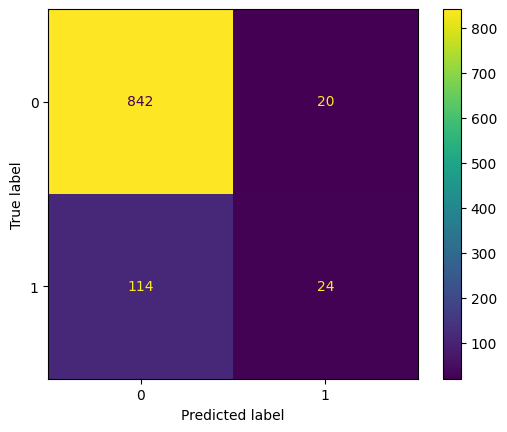

0.866


In [90]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
calculate(log_model)

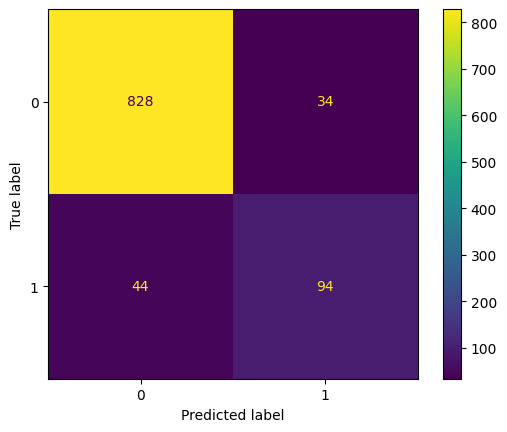

0.922


In [91]:
stack_model = StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)), ('dt', DecisionTreeClassifier())], final_estimator=SVC())
stack_model.fit(X_train, y_train)
calculate(stack_model)

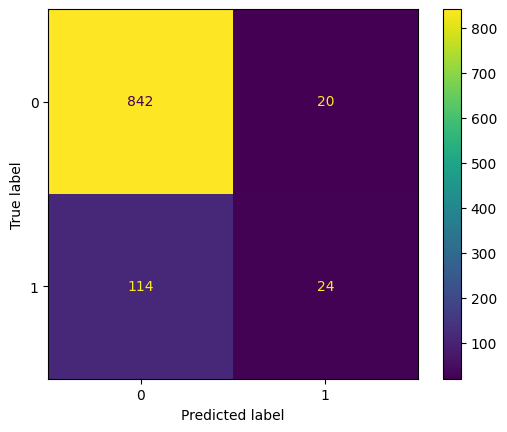

0.866


In [92]:
bag_model = BaggingClassifier(estimator=LogisticRegression(max_iter=1000))
bag_model.fit(X_train, y_train)
calculate(bag_model)

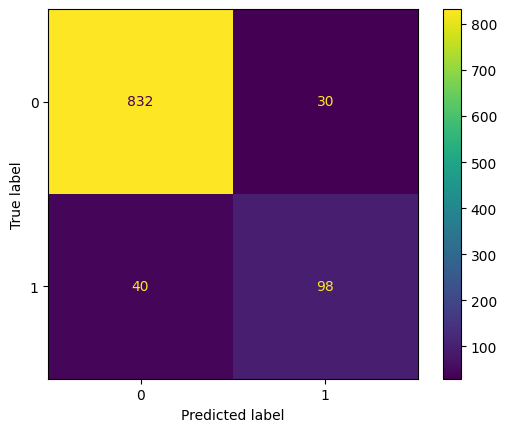

0.93


In [93]:
ab_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=0)
ab_model .fit(X_train, y_train)
calculate(ab_model)

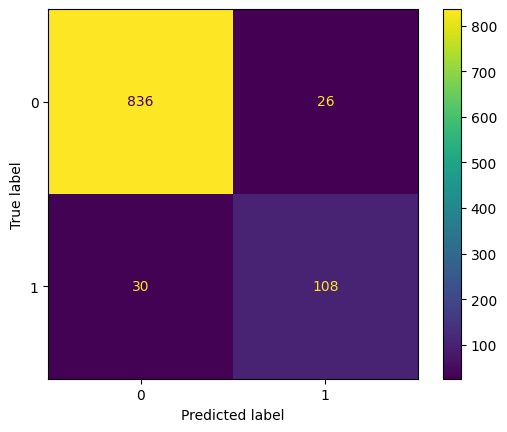

0.944


In [94]:
gb_model = GradientBoostingClassifier(max_depth=5, n_estimators=150, random_state=0, learning_rate=1)
gb_model.fit(X_train, y_train)
calculate(gb_model)

## PCA

In [95]:
pca = PCA().fit(X)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3)

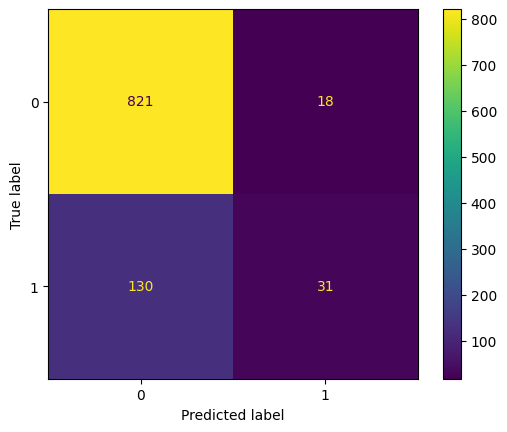

0.852


In [96]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
calculate(log_model)

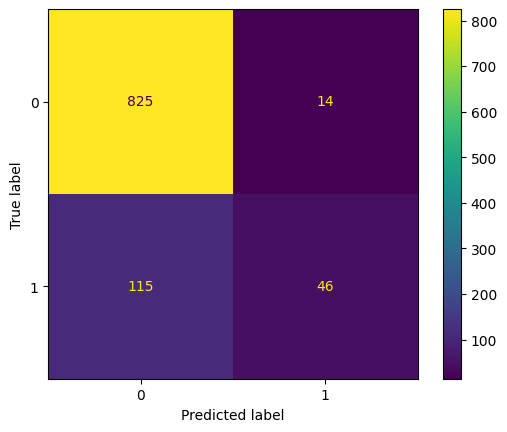

0.871


In [97]:
stack_model = StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)), ('dt', DecisionTreeClassifier())], final_estimator=SVC())
stack_model.fit(X_train, y_train)
calculate(stack_model)

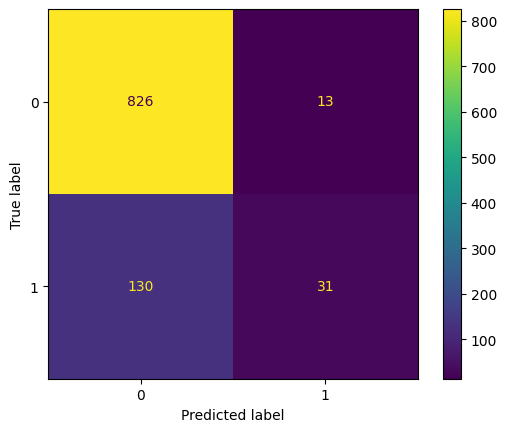

0.857


In [98]:
bag_model = BaggingClassifier(estimator=LogisticRegression(max_iter=1000))
bag_model.fit(X_train, y_train)
calculate(bag_model)

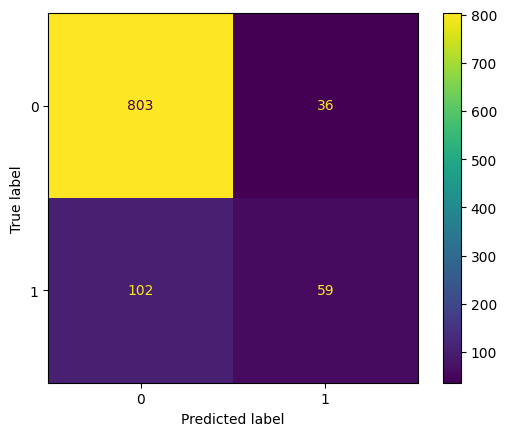

0.862


In [99]:
ab_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=0)
ab_model .fit(X_train, y_train)
calculate(ab_model)

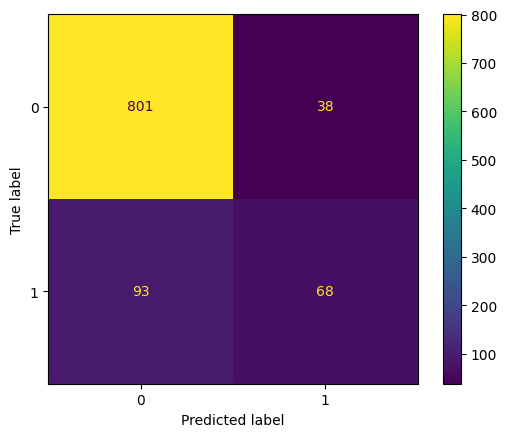

0.869


In [100]:
gb_model = GradientBoostingClassifier(max_depth=5, n_estimators=150, random_state=0, learning_rate=1)
gb_model.fit(X_train, y_train)
calculate(gb_model)

Сравнение результатов:

*  Logistic Regression 0.866 - 0.852
*  Stacking Classifier 0.922 - 0.871

*  Bagging Classifier 0.866 - 0.857

*  AdaBoost Classifier 0.93 - 0.862

*  Gradient Boosting Classifier 0.944 - 0.869

оценка моделей ухудшилась после применения PCA. Лучший результат показал Gradient Boosting Classifier